# Estimating annual probabilities of disturbance within AIMS LTMP data, 1995-2017

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from theano.compile.ops import as_op
import seaborn as sns
import scipy.stats as ss
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])
invlogit = tt.nnet.sigmoid

def zerone(x):
    return (x-min(x))/max(x-min(x))

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

In [3]:
# Import ltmp data
xdata = pd.read_csv('GBR_ltmp.csv')

In [4]:
# Set reefyear
reefyear = np.array([r+str(y) for r,y in zip(xdata.REEF_NAME.values,xdata.REPORT_YEAR.values)])
# Create new cluster code column
xdata['ClustCode'] = xdata.CLUSTER.values
# Substitute ClusterNames for Cluster codes
Clust_dict = ['CL1','CL2','CL3','CL4']
Clust_names = np.array(['Porities-A','Mixed','Soft-coral','Acropora'])
xdata['CLUSTER'] = np.array(Clust_names)[match(xdata.ClustCode.values,Clust_dict)]
xdata['reefNyear'] = xdata.REEF_NAME+'_'+xdata.REPORT_YEAR.astype(str)

In [5]:
np.shape(xdata)

(15870, 39)

In [6]:
# Get rid of missing years
xdata = xdata.loc[xdata.HC > 0]
xdata = xdata.loc[xdata.HC_1 > 0]
np.shape(xdata)

(8487, 39)

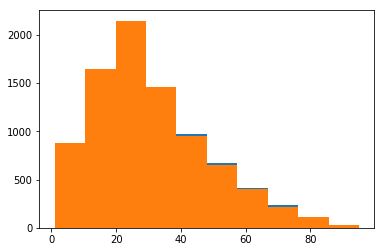

In [7]:
# Hard coral - out of 200 points
HC = np.round(xdata.HC.values)+1
nobs = len(HC)
plt.hist(HC)

# Lag-1 hard coral
HC1 = np.round(xdata.HC_1.values)+1
plt.hist(HC1)

# log lag-1 hard coral
lHC = np.log(HC)
lHC1 = np.log(HC1)

# Number of observations
nobs = len(lHC1)

### Get data
Here we want to estimate the proability of each disturbance type on a given reef each year

In [8]:
# Index each reef to a given cluster
Cluster,Ic = subindexall(xdata.CLUSTER.values,xdata.REEF_NAME.values)
ncluster = len(Cluster)

# Index each transect to a given reef
Reef,Ir = indexall(xdata.REEF_NAME.values)
nreefs = len(Reef)

# Index each transect to a given cluster
Cluster_t,Ict = indexall(xdata.CLUSTER.values)
nct = len(Cluster_t)

# Year
year = xdata.REPORT_YEAR.values
nyears = len(np.unique(year))
YR = xdata.REPORT_YEAR.values-1995
maxyr = max(YR)

# Disturbance array
DIST = ['CoTS','Cyclones','Bleaching','Disease','Unknown']

# Index constant reef-scale covariates
rindx = np.array([list(xdata.REEF_NAME.values).index(x) for x in Reef])

# Get water quality values
WQ = xdata.PFsum.values[rindx]
# Mean water quality per cluster
Mean_wq = np.array([np.mean(WQ[Ic==i]) for i in range(ncluster)])
# Log water quality
lWQ = np.log(WQ)
# Zero-centred water quality per cluster
ZcWQ = WQ-Mean_wq[Ic]
# Primary wq
pWQ = xdata.PFp.values[rindx]
# Secondary wq
sWQ = xdata.PFs.values[rindx]
# Tertiary wq
tWQ = xdata.PFt.values[rindx]

# Get zoning for resistance
ZONE = (xdata.iZONE.values+xdata.sZONE.values>0)*1
# Get zoning values for recovery
rZONE = ZONE[rindx]

In [9]:
# Make missing disturbances 'Unknown'
Dist_ = xdata.DISTURBANCE.values
Dist_[Dist_=='-999'] = 'U'
# Create unknown disturbance array
UNK = (Dist_=='U')*1

# CoTS outbreaks
CoTS = (xdata.COTS.values>0)*1

# Cyclones
STORM = (xdata.STORM.values>0)*1

# Bleaching
BLEACH = (xdata.BLEACHING.values>0)*1

# Disease
DISEASE = (xdata.DISEASE.values>0)*1

# log-Herbivory
tmp = xdata.HERB.values
tmp[tmp==-999] = np.mean(tmp[tmp!=-999])
HERB = stdize(np.log(tmp+1))

# Bayesian model for annual average disturbance rates

In [10]:
Model = pm.Model()
with Model:
    # Logit priors for P(disturbance|transect,year)
    beta_cots = pm.Normal("beta_cots", mu=0.0, tau=0.1, shape=ncluster)
    beta_storms = pm.Normal("beta_storms", mu=0.0, tau=0.1, shape=ncluster)
    beta_bleach = pm.Normal("beta_bleach", mu=0.0, tau=0.1, shape=ncluster)
    beta_disease = pm.Normal("beta_disease", mu=0.0, tau=0.1, shape=ncluster)
    beta_unknown = pm.Normal("beta_unknown", mu=0.0, tau=0.1, shape=ncluster)
    
    # Probabilities
    p_cots = pm.Deterministic('p_cots', invlogit(beta_cots))
    p_storms = pm.Deterministic('p_storms', invlogit(beta_storms))
    p_bleach = pm.Deterministic('p_bleach', invlogit(beta_bleach))
    p_disease = pm.Deterministic('p_disease', invlogit(beta_disease))
    p_unknown = pm.Deterministic('p_unknown', invlogit(beta_unknown))
    
    # Likelihoods
    obs_cots = pm.Bernoulli('obs_cots', p_cots[Ict], observed=CoTS)
    obs_storms = pm.Bernoulli('obs_storms', p_storms[Ict], observed=STORM)
    obs_bleach = pm.Bernoulli('obs_bleach', p_bleach[Ict], observed=BLEACH)
    obs_disease = pm.Bernoulli('obs_disease', p_disease[Ict], observed=DISEASE)
    obs_unknown = pm.Bernoulli('obs_unknown', p_unknown[Ict], observed=UNK)

In [11]:
# Sampling
with Model:
    # Draw samples
    trace = pm.sample(10000, progressbar=True, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_unknown, beta_disease, beta_bleach, beta_storms, beta_cots]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:40<00:00, 208.58draws/s]


In [12]:
pm.stats.summary(trace);

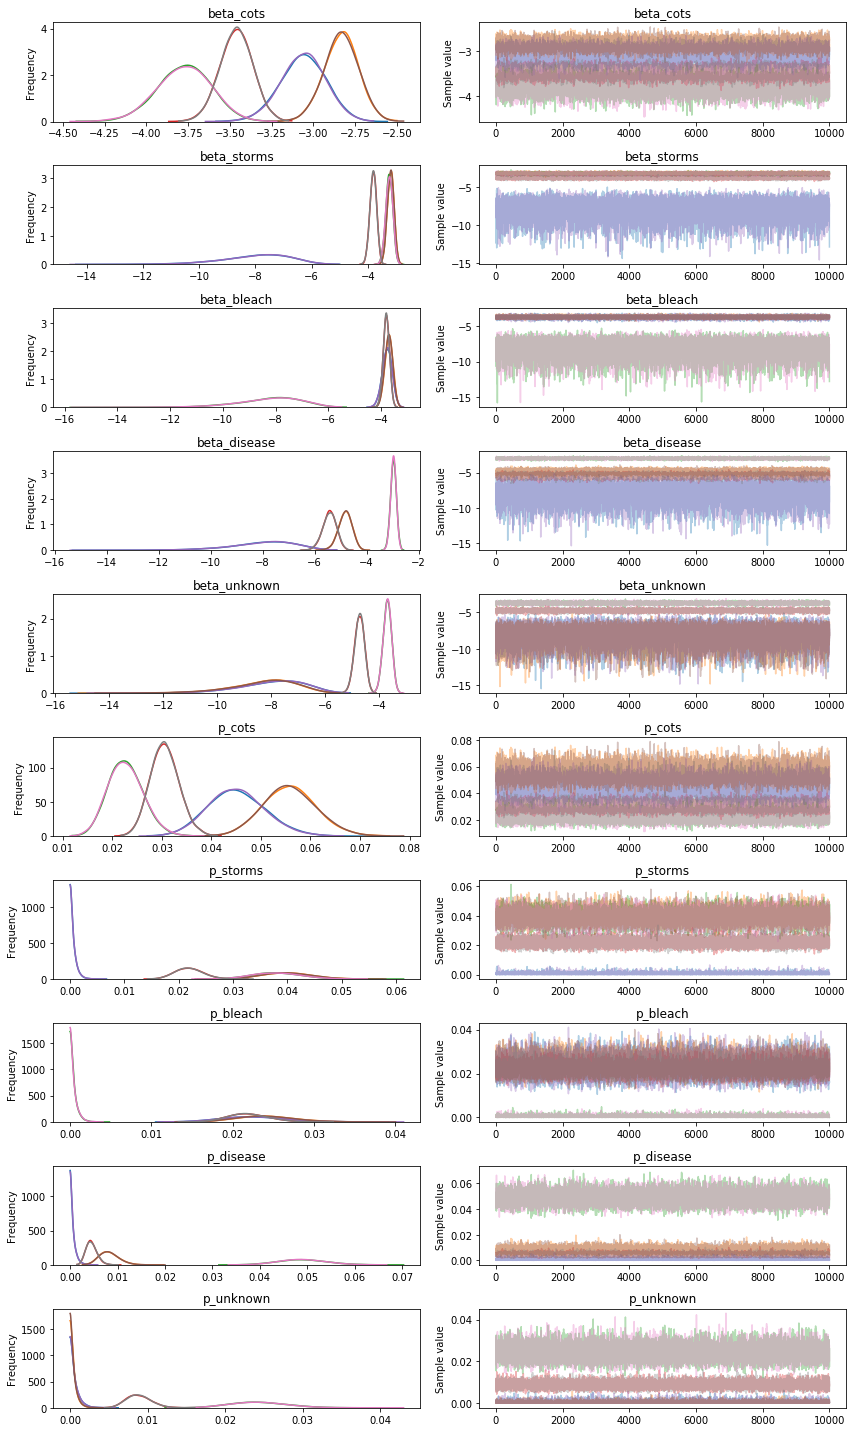

In [13]:
pm.traceplot(trace);

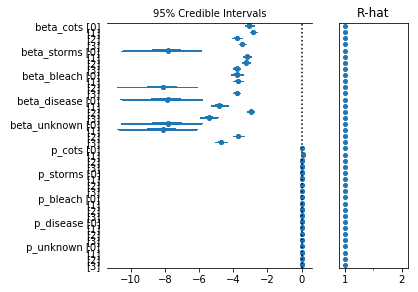

In [14]:
pm.forestplot(trace);

In [15]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)

In [16]:
out.to_csv('Disturbance_results.csv')
out.head()

,beta_cots__0,beta_cots__1,beta_cots__2,beta_cots__3,beta_storms__0,beta_storms__1,beta_storms__2,beta_storms__3,beta_bleach__0,beta_bleach__1,...,p_bleach__2,p_bleach__3,p_disease__0,p_disease__1,p_disease__2,p_disease__3,p_unknown__0,p_unknown__1,p_unknown__2,p_unknown__3
0,-3.040999,-2.875803,-4.013753,-3.440930,-7.709169,-3.209174,-3.125330,-3.888941,-3.797785,-3.801110,...,0.000202,0.019734,0.003316,0.007549,0.042863,0.003970,0.000604,0.000103,0.027958,0.007918
1,-3.040999,-2.875803,-4.013753,-3.440930,-7.709169,-3.209174,-3.125330,-3.888941,-3.797785,-3.801110,...,0.000202,0.019734,0.003316,0.007549,0.042863,0.003970,0.000604,0.000103,0.027958,0.007918
2,-2.951321,-2.729624,-3.616576,-3.546761,-7.907086,-3.083724,-3.183339,-3.630468,-4.096026,-3.654962,...,0.000314,0.023611,0.000033,0.009924,0.046892,0.005089,0.000517,0.001230,0.020687,0.008276
3,-3.155352,-2.876854,-4.049501,-3.395578,-7.560301,-3.285946,-3.252056,-3.990368,-3.615102,-3.738907,...,0.000306,0.021805,0.000140,0.006349,0.053078,0.003394,0.000580,0.000012,0.028450,0.007604
4,-3.077437,-2.769116,-3.560040,-3.514760,-7.483106,-3.200422,-3.140329,-3.686319,-3.960122,-3.651508,...,0.000547,0.021246,0.001458,0.005167,0.046846,0.005865,0.000656,0.000873,0.018983,0.010839
